In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [22]:
import numpy as np
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost
from datetime import datetime
import pickle
import warnings
from scipy.stats import mannwhitneyu
import scipy.special

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, SplineTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibrationDisplay

number of features: 36
entries in training set: 76518
entries in testing set:  51012


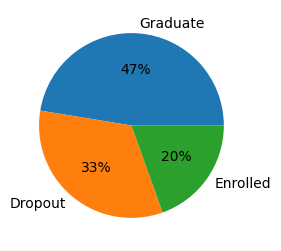

In [47]:
# define the base path to the dataset directory
data_path = 'playground_series/s04e06_classification_with_an_academic_success_dataset/data/'

# construct file paths for the training and testing datasets using os.path.join for system-independent path handling
train_path = os.path.join(data_path,'train.csv')
test_path  = os.path.join(data_path, 'test.csv')

#load the training and testing dataset. set the 'id' column as the index of the DataFrame
df_train = pd.read_csv(train_path, index_col='id')
df_test = pd.read_csv(test_path, index_col='id')

# retrieve and store the list of feastures from the test dataset
initial_features = list(df_test.columns)

# display basic statistics: number of features and entreis in each dataset
print(f'number of features: {len(initial_features)}')
print(f'entries in training set: {len(df_train)}')
print(f'entries in testing set:  {len(df_test)}')

# visualise the distribution of the target variable in the training dataset 
def visualise_target_distribution(df):
    temp = df['Target'].value_counts()
    plt.figure(figsize=(3,3))
    plt.pie(temp, labels=temp.index, autopct='%.0f%%')
    plt.show()
visualise_target_distribution(df_train)

In [48]:
# initialize a LabelEncoder object to transform non-numeric tabels into numerical labels
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(df_train['Target'])

In [49]:
# list of categorical features in the dataset
cat_features = ['Marital status',
                'Application mode',
                'Course',
                'Previous qualification',
                'Nacionality',
                "Mother's qualification",
                "Father's qualification",
                "Mother's occupation",
                "Father's occupation"]

def convert_cat_dtypes(df, features):
    '''
    Convert specified columns in a DataFrame to categorical data types.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        features (list of str): A list of column naes to be converted to categorical type.

    Returns:
        pd.DataFrane: The DataFrame with the specified columns converted to categorical types.
    '''
    for feature in features:
        dtype = pd.CategoricalDtype(categories=list(set(df[feature])), ordered=False)
        df[feature] = df[feature].astype(dtype)
    return df

df_train = convert_cat_dtypes(df_train, cat_features)

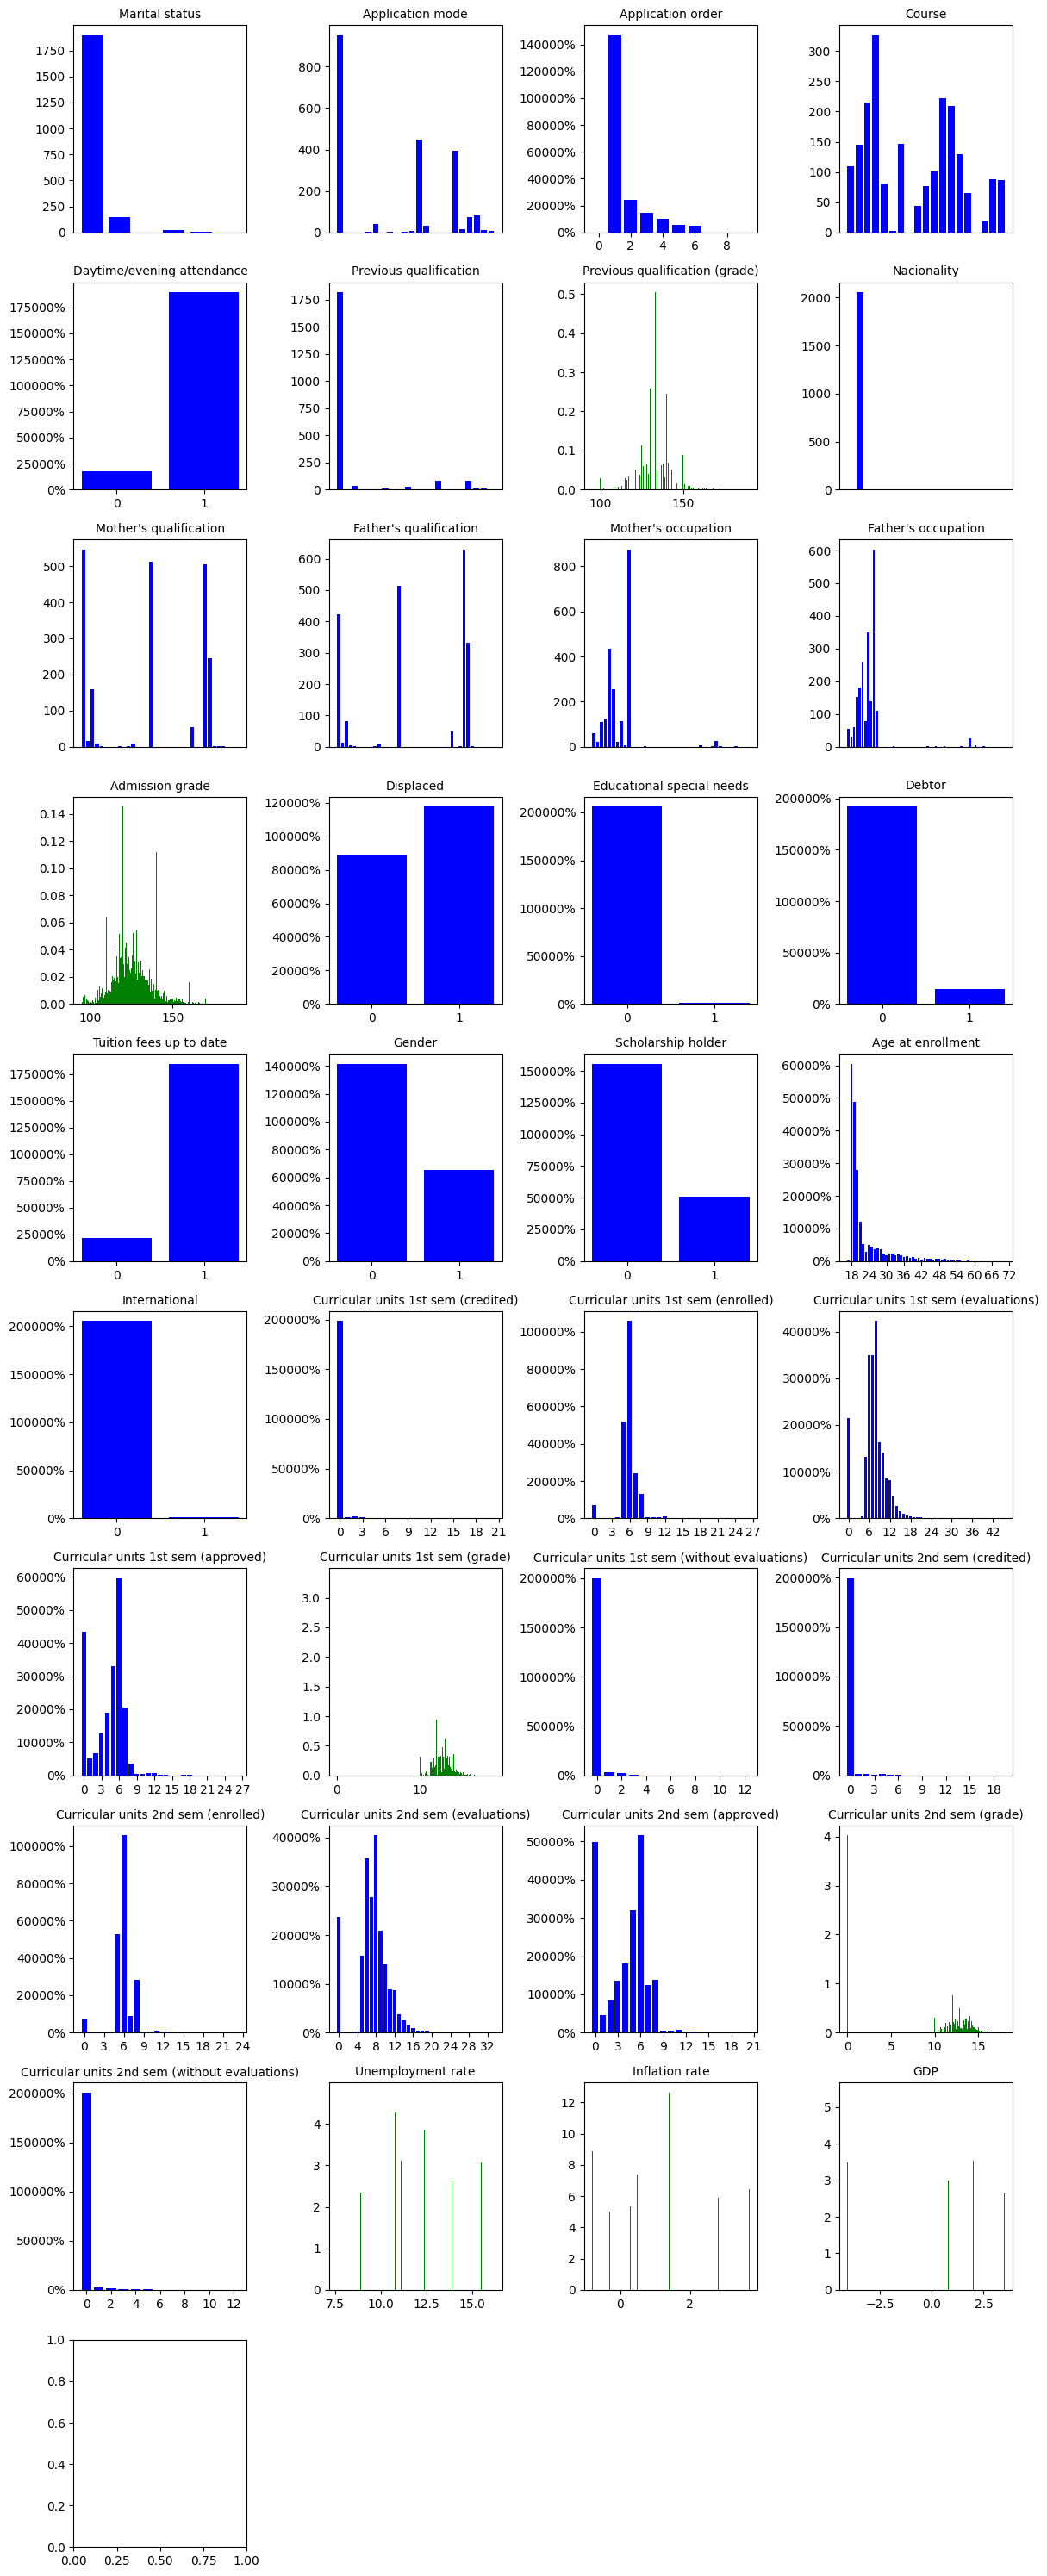

In [61]:
def display_feature_graphs(df, features=None):
    '''
    Display histograms or bar charts for each feature in the given DataFrame.

    Args:
        df (DataFrame): The DataFrame containing the features to be plotted.
        features (list of str, optional): List of column names to plot. Plots all columns if None.
    
    Generates a grid of plots with histograms for numerical features and bar charts for categorical features.
    '''
    if features is None:
        features = df.columns.tolist()

    num_features = len(features)
    num_rows = (num_features + 3) // 4

    fig, axs = plt.subplots(num_rows, 4, figsize=(12, max(20, 3 * num_rows)))
    axs = axs.ravel()

    for col, ax in zip(initial_features, axs):
        if df[col].dtype == float:
            ax.hist(df[col], bins=300, density=True, color='g')
        elif df[col].dtype == 'category':
            vc = df[col].cat.codes.value_counts() / num_features
            ax.bar(vc.index, vc, color='b')
            ax.set_xticks([])
        else:
            vc = df[col].value_counts() / num_features
            ax.bar(vc.index, vc, color='b')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_formatter('{x:.0%}')
        ax.set_title(col, fontsize=10)

    for idx in range(num_features, len(axs)):
        fig.delaxes(axs[idx])  # Remove unused axes
        
    plt.tight_layout()
    plt.show()
display_feature_graphs(df_train)

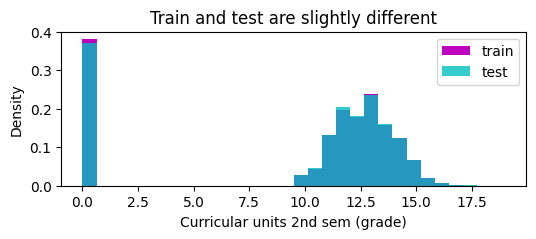

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_comparison(df1, df2, column_name, label1, label2, title, alpha=0.8):
    """
    Plot overlaid histograms for the specified column from two different DataFrames.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        column_name (str): The column name to plot the histograms for.
        label1 (str): Label for the histogram of the first DataFrame.
        label2 (str): Label for the histogram of the second DataFrame.
        title (str): Title for the plot.
        alpha (float, optional): Transparency for the second histogram. Default is 0.8.

    This function creates a plot with two overlaid histograms, useful for comparing the
    distribution of a specific feature across two different datasets. The histograms
    are normalized to show density instead of counts to facilitate comparison.
    """
    plt.figure(figsize=(6, 2))
    # Plot histogram for the first dataset
    plt.hist(df1[column_name], bins=np.linspace(0, 19, 31), density=True, color='m', label=label1)
    # Plot histogram for the second dataset
    plt.hist(df2[column_name], bins=np.linspace(0, 19, 31), density=True, alpha=alpha, color='c', label=label2)
    # Setting labels and titles
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage of the function:
plot_histogram_comparison(df_train, df_test, 'Curricular units 2nd sem (grade)', 'train', 'test', 'Train and test are slightly different')